In [32]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [33]:
# Analyze reliability, bandwidth, energy
data = []
refdir = "../lfsr"
allbad = pd.read_csv("data/bad.csv", delimiter="\t", header=None)
allbad = allbad[allbad.columns[-48:]].values
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          continue

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                bads = []
                for i in range(65535):
                    for j in range(48):
                        if (j in [2, 7, 16, 19, 23, 24, 29, 33, 38, 39, 43]) or allbad[i][j]: #[16,19,24,29,38,43]:
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                          if ((i + j) % (2**bpc)) != postread[i][j]:
                            bads.append([i, j])
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                          if refvec[i][j] != postread[i][j]:
                            bads.append([i, j])
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                print(confmat)
                bads = pd.DataFrame(bads, columns=["addr", "i"])
                bads.to_csv(f"data/bad/bad_{mode}_{alias}_{att}.csv", index=False)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data

1bpc_bwa_996
[[1123779   75785]
 [   1751 1202645]]
[[1191902    7662]
 [   1229 1203167]]
[[1195730    3834]
 [    770 1203626]]
[[1196246    3318]
 [    637 1203759]]
[[1196885    2679]
 [    610 1203786]]
[[1196954    2610]
 [    560 1203836]]
[[1196950    2614]
 [    549 1203847]]
[[1197037    2527]
 [    554 1203842]]
[[1197048    2516]
 [    554 1203842]]
[[1197063    2501]
 [    549 1203847]]
[[1197084    2480]
 [    559 1203837]]
[[1197103    2461]
 [    558 1203838]]
[[1196853    5446]
 [    706 1200955]]
[[1195755    6544]
 [    671 1200990]]
[[1199524    2775]
 [    586 1201075]]
[[1199996    2303]
 [    541 1201120]]
[[1200236    2063]
 [    522 1201139]]
[[1200277    2022]
 [    514 1201147]]
[[1200312    1987]
 [    516 1201145]]
[[1200308    1991]
 [    514 1201147]]
[[1200376    1923]
 [    511 1201150]]
[[1200401    1898]
 [    505 1201156]]
[[1200391    1908]
 [    504 1201157]]
[[1200441    1858]
 [    504 1201157]]
1bpc_bwa_0
1bpc_pba_571
[[1163987   35577]
 [ 13837

,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_bwa_996_cb,1,1,0.05647134780883789,0.056362,0.005554,1.302056e-10,3.052706e-18,4.265250e+07,0.032253,...,0.179592,65536,131072,327680,65536,65536,5636152,3637248,1204023,1211865
1,1bpc_bwa_996_cb,2,1,0.08271574974060059,0.082654,0.005030,1.729426e-10,5.946186e-18,2.908462e+07,0.003698,...,0.060815,65536,23232,458750,73437,80866,8265400,8045168,1213024,1236441
2,1bpc_bwa_996_cb,4,1,0.08936953544616699,0.089385,0.005028,1.869550e-10,6.951441e-18,2.689443e+07,0.001915,...,0.043763,65536,13144,486865,69193,103137,8938506,8272229,1207803,1261579
3,1bpc_bwa_996_cb,8,1,0.1027672290802002,0.102647,0.005010,2.139346e-10,9.134814e-18,2.341970e+07,0.001645,...,0.040561,65536,12889,538283,72159,151334,10264691,8340901,1210769,1321799
4,1bpc_bwa_996_cb,16,1,0.12894344329833984,0.128881,0.005001,2.681130e-10,1.437410e-17,1.865250e+07,0.001368,...,0.036989,65536,12763,639859,77709,247234,12888135,8462172,1216279,1434491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2bpc_pba_422_lfsr,128,2,2.8309125900268555,2.830640,0.004264,2.510686e-09,1.478154e-15,1.698528e+06,0.047795,...,0.328702,65536,27395,7554728,2621601,3919421,283063979,24514319,9595016,5429392
212,2bpc_pba_422_lfsr,256,2,4.07776665687561,4.077439,0.004277,3.627423e-09,3.076298e-15,1.179152e+06,0.046687,...,0.326163,65536,24704,10683983,2765835,6898229,407743898,27841416,9566056,8707720
213,2bpc_pba_422_lfsr,512,2,6.454075336456299,6.453736,0.004273,5.736240e-09,7.699833e-15,7.449824e+05,0.046301,...,0.325062,65536,23701,16642162,3009779,12615226,645373620,34160256,9637731,14986015
214,2bpc_pba_422_lfsr,1024,2,11.162652015686035,11.162358,0.004292,9.963726e-09,2.313239e-14,4.307262e+05,0.046246,...,0.324870,65536,23178,28454075,3533761,23899109,1116235758,47119347,10154714,27382542


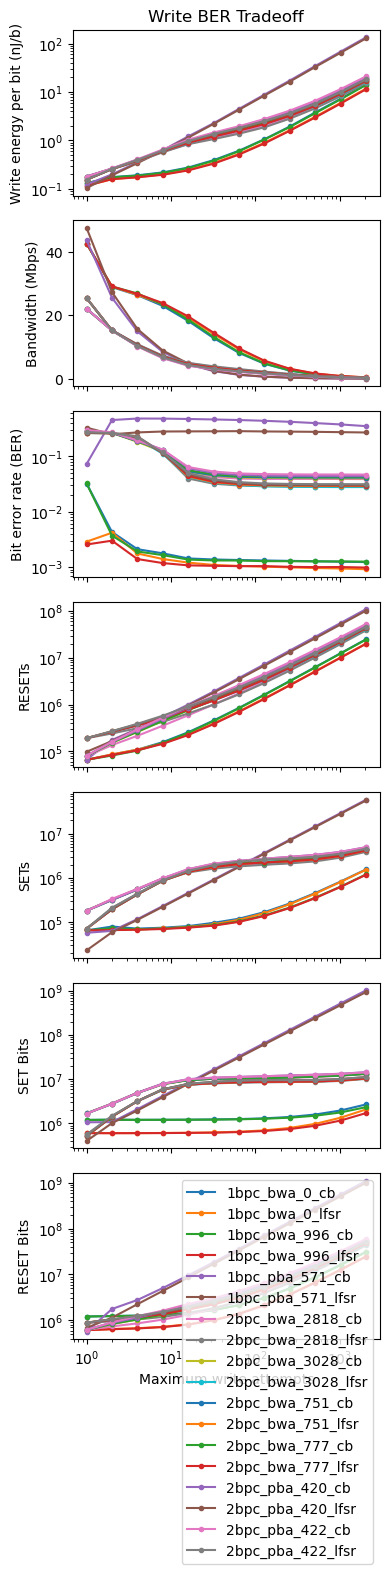

: 

In [34]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  axs[1].set_ylabel("Bandwidth (Mbps)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()